In [1]:
import torch
import torch.nn as nn   
import tiktoken

Causal Attention

In [124]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2) # Changed transpose
        attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights) # New

        context_vec = attn_weights @ values
        return context_vec

Multihead attention

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)   #reshape from 1,3,6 to 1,3,2,3 (1 batch of 3 token having 2 heads of 3 dimensions each)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        # now these are grouped by head , each head contains all the token in the emb dimenions
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)  #keys.shape[-1] is head_dim
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [2]:
import sys
print(sys.version)

3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]


In [3]:
GPT_Config_124M = {
    "vocab_size": 50257,    # size of vocabulary
    "context_length": 1024,  # maximum context length meaning number of tokens in a sequence
    "emb_dim": 768,        # embedding dimension
    "n_heads": 12,        # number of attention heads
    "n_layers": 12,      # number of transformer blocks
    "dropout": 0.1,      # dropout rate from causal attention
    "qkv_bias": False,   #query key value bias
}

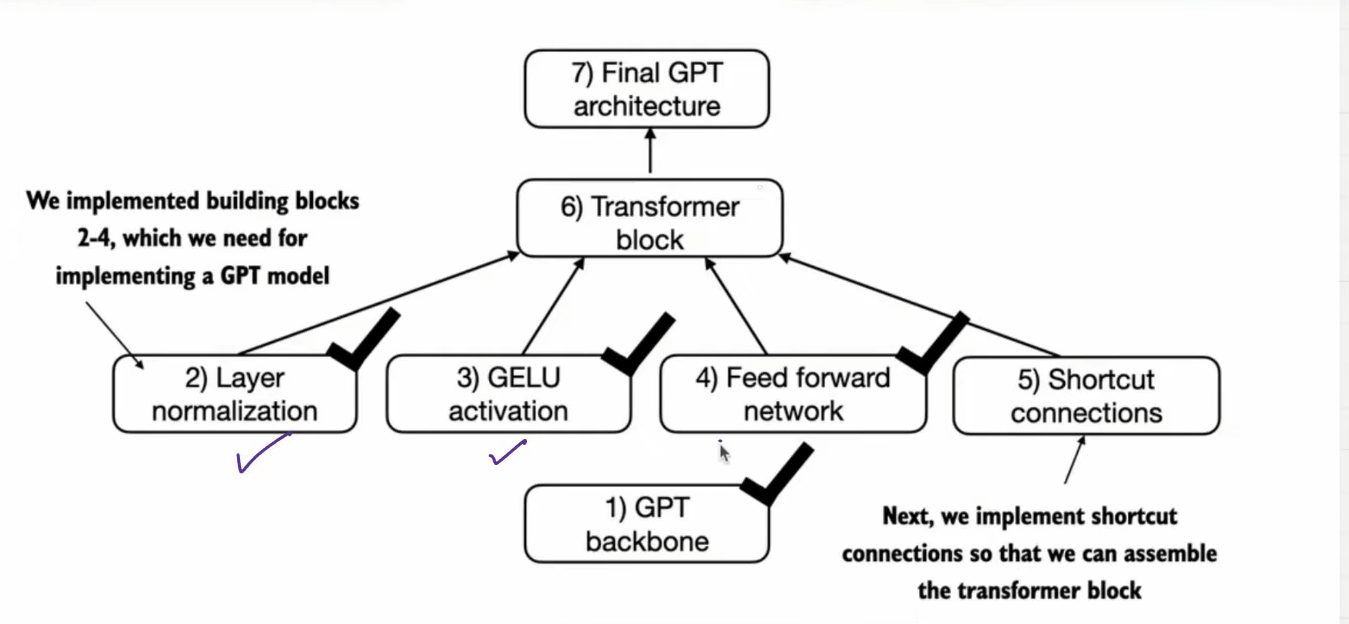

In [ ]:
class DummyGPTv1(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_embedding = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.position_embedding = nn.Embedding(cfg["context_length"], cfg["emb_dim"])   # we are going to look at context length i.e number of words lets say in a sentence we want to know position with is 1024, is context length. 
        self.drop_emb= nn.Dropout(cfg["dropout"])
        self.trf_block= nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])  #stacking transformer blocks
        self.final_norm= NormalizationLayer(cfg["emb_dim"])
        self.out_layer=nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)   # final output layer to get the probabilities of each token in the vocabulary
    
    
    def forward(self, input):
        batch_size, seq_length = input.size()
        token_emb=self.token_embedding(input)   # we are looking for these inputs in the embedding metrics that we have created
        position_emb=self.position_embedding(torch.arange(seq_length,device=input.device))  # it will look at the token length (lets say 4) and then find from (0,1,2,3) the position embedding vector for each token from the position embedding matrix defined in class 
        x= token_emb + position_emb
        x=self.drop_emb(x)
        x=self.trf_block(x)   # passing through transformer blocks
        x=self.final_norm(x)
        logits=self.out_layer(x)
        # final output layer
        return logits  #return probabilities of all token in the vocabulary for each Input word position in the sequence to predict what comes next, so size will be token size (here 4) and since dictonary size is 50257, so (4,50257) will be the output size.
        

        

class NormalizationLayer(nn.Module):
    def __init__(self, cfg):    
        super().__init__()    
    def forward(self, x):
        return x
    

In [197]:
tokenizer= tiktoken.get_encoding("gpt2")
batch=[]
txt1= "Every effort moves you"
txt2= "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch= torch.stack(batch, dim=0) # stacking into batch of size 2
print(batch) 




tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [6]:
torch.manual_seed(123)
model= DummyGPTv1(GPT_Config_124M)

logits= model(batch)

print("Logits size:", logits.size())  # expect (batch size, sequence length, vocab size) => (2, 5, 50257)
print("Logits:", logits)

Logits size: torch.Size([2, 4, 50257])
Logits: tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


Layer Normalization

In [ ]:
torch.manual_seed(123)
batch_example= torch.randn(2,4) # two batch each of  5 columns
layer= nn.Sequential(nn.Linear(5,6), nn.ReLU())  # sequential layers taking 5 inputs one by one batch and giving 6 outputs
out= layer(batch_example)
print(out)




tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [8]:
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [9]:
mean=out.mean(axis = -1, keepdim=True)
std=out.std(axis = -1, keepdim=True)
out_normalized= (out - mean) / (std + 0.00001)
print(out_normalized)

tensor([[ 0.6158,  1.4125, -0.8718,  0.5872, -0.8718, -0.8718],
        [-0.0189,  0.1121, -1.0876,  1.5172,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)


In [150]:
class LayerNormalization(nn.Module):
    def __init__(self,normalized_shape, eps=0.00001):  # normalized_shape is usually the number of dimesions of embedding 
        # since normalization doesnt change the dimesion 
        super().__init__()
        self.eps= eps
        self.gamma= nn.Parameter(torch.ones(normalized_shape))  # scale parameter
        self.beta= nn.Parameter(torch.zeros(normalized_shape))  # shift parameter
       
    def forward(self, x):
        mean=x.mean(axis=-1, keepdim=True)
        std=x.std(axis=-1, keepdim=True)
        out_normalized= (x - mean) / torch.sqrt (std + self.eps)
        #return out_normalized
        return self.gamma * out_normalized + self.beta  # scale and shift
    

In [151]:
norm= LayerNormalization((4))
batch_example= torch.randn(2,4)
normalized_output= norm.forward(batch_example)
batch.shape


torch.Size([2, 4])

In [152]:
print(normalized_output)
normalized_output.shape

tensor([[-0.8011,  0.3994, -0.6545,  1.0561],
        [-0.4836, -0.5292, -0.4258,  1.4387]], grad_fn=<AddBackward0>)


torch.Size([2, 4])

Writing Gelu Activation function

In [127]:
class GeluActivation(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1+ torch.tanh(
            torch.sqrt(torch.tensor(2.0/torch.pi)) * 
            (x + 0.044715 * torch.pow(x,3))))  # approcximation of gelu

In [35]:
GPT_Config_124M = {
    "vocab_size": 50257,    # size of vocabulary
    "context_length": 1024,  # maximum context length meaning number of tokens in a sequence
    "emb_dim": 768,        # embedding dimension
    "n_heads": 12,        # number of attention heads
    "n_layers": 12,      # number of transformer blocks
    "dropout": 0.1,      # dropout rate from causal attention
    "qkv_bias": False,   #query key value bias
}

Sequential Module works this way :

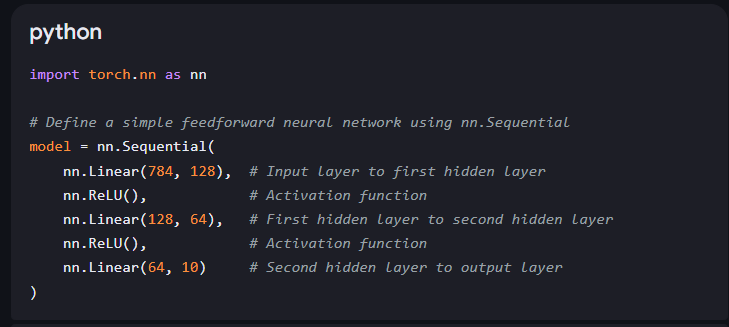

In [128]:
class FeedforwardNetwork(nn.Module):
    def __init__(self, cfg):  # cfg is configuration dictionary
        super().__init__()
        self.layers= nn.Sequential(nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),  # Expansion layer
                                   GeluActivation(),  # activation function
                                   nn.Linear(4* cfg["emb_dim"], cfg["emb_dim"])   # Compression layer
                                   )
    def forward(self, x):
        return self.layers(x)

In [111]:
print("Feedforward Network Test")
fn= FeedforwardNetwork(GPT_Config_124M)


Feedforward Network Test


In [112]:
X= torch.rand(2,3,768)  # batch size 2, sequence length 3, embedding dimension 768
out_fn= fn.forward(X)   
print("Feedforward Network output size:", out_fn.size())  # expect (2,3,768)
print("Feedforward Network output:", out_fn)

Feedforward Network output size: torch.Size([2, 3, 768])
Feedforward Network output: tensor([[[ 0.1203,  0.1817,  0.0349,  ..., -0.0482, -0.0392, -0.2630],
         [ 0.1028,  0.2454,  0.0311,  ..., -0.0099, -0.0109, -0.2420],
         [ 0.0651,  0.0944,  0.1190,  ..., -0.0718, -0.1305, -0.2930]],

        [[ 0.1312,  0.0904,  0.0360,  ..., -0.0876, -0.1053, -0.2458],
         [ 0.1190,  0.2000, -0.0530,  ..., -0.0584, -0.0348, -0.2114],
         [ 0.0957,  0.0938,  0.1182,  ..., -0.1112, -0.0169, -0.1608]]],
       grad_fn=<ViewBackward0>)


Shortcut connections

In [113]:
class Exampleshortcut(nn.Module):
    def __init__(self, layer_size, use_shortcut=True):
        super().__init__()
        self.use_shortcut= use_shortcut
        self.layers = nn.ModuleList( [
        (nn.Sequential(nn.Linear(layer_size[0], layer_size[1], GeluActivation()))),
        (nn.Sequential(nn.Linear(layer_size[1], layer_size[2], GeluActivation()))),
        (nn.Sequential(nn.Linear(layer_size[2], layer_size[3], GeluActivation()))),
        (nn.Sequential(nn.Linear(layer_size[3], layer_size[4], GeluActivation()))),
        (nn.Sequential(nn.Linear(layer_size[4], layer_size[5], GeluActivation())))
        ])
    def forward(self, x):
        # create an output
        for layer in self.layers:
            layer_output= layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x= layer_output+x  # adding shortcut connection
            
            else:
                x=layer_output
    
        return x            
        

In [114]:
torch.manual_seed(123)
layer_sizes= [2,2,2,2,2,1]
torch.manual_seed(125)
model_shortcut= Exampleshortcut(layer_sizes, use_shortcut=False)
input= torch.tensor([[1.0, -1.0]])


In [117]:
def print_gradients(model,x):
    #forward pass
    output= model(x)
    target= torch.tensor([[0.]])
    loss= nn.MSELoss()(output, target)
    #backward pass
    loss.backward()
    for name, param in model.named_parameters():
        if 'weight' in name:
            #print the mean absolute graidents of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")
          

In [118]:
print_gradients(model_shortcut, input)

layers.0.0.weight has gradient mean of 0.5383838415145874
layers.1.0.weight has gradient mean of 0.6849905252456665
layers.2.0.weight has gradient mean of 2.688265562057495
layers.3.0.weight has gradient mean of 1.9808193445205688
layers.4.0.weight has gradient mean of 4.109770774841309


Coding the Transformer architecture 

In [132]:
GPT_Config_124M = {
    "vocab_size": 50257,    # size of vocabulary
    "context_length": 1024,  # maximum context length meaning number of tokens in a sequence
    "emb_dim": 768,        # embedding dimension
    "n_heads": 12,        # number of attention heads
    "n_layers": 12,      # number of transformer blocks
    "dropout": 0.1,      # dropout rate from causal attention
    "qkv_bias": False,   #query key value bias
}

In [162]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attention = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            dropout=cfg["dropout"],
            num_heads=cfg["n_heads"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff= FeedforwardNetwork(cfg)
        self.norm1= LayerNormalization(cfg["emb_dim"])
        self.norm2= LayerNormalization(cfg["emb_dim"])
        self.dropout= nn.Dropout(cfg["dropout"])
    
    def forward(self, x):
        shortcut = x
        
        x= self.norm1(x)
        x= self.attention(x)   #shape [batch size, num_tokens, embedding_size ]
        x= self.dropout(x)
        
        x = x + shortcut   # add the original input back
        
        
        # shortcut connection for feedback forward block
        shortcut= x
        
        x= self.norm2(x)
        x = self.ff(x)
        x= self.dropout(x)
        x= x + shortcut
        
        return x
    

In [170]:
torch.manual_seed(123)
x= torch.rand(2,4, 768)    # creting 2 batch of 4 tokens with 768 dimensions
block = TransformerBlock(GPT_Config_124M)
output= block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)



Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


Assemble a fully working version of originial 124M parameter version of gpt-2

In [209]:
class DummyGPTv1(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_embedding = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.position_embedding = nn.Embedding(cfg["context_length"], cfg["emb_dim"])   # we are going to look at context length i.e number of words lets say in a sentence we want to know position with is 1024, is context length. 
        self.drop_emb= nn.Dropout(cfg["dropout"])
        
        # Use a placeholder for transformer block
        self.trf_block= nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])  #stacking transformer blocks
        self.final_norm= NormalizationLayer(cfg["emb_dim"])
        self.out_layer=nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)   # final output layer to get the probabilities of each token in the vocabulary
    
    
    def forward(self, input):
        batch_size, seq_length = input.shape
        token_emb=self.token_embedding(input)   # we are looking for these inputs in the embedding metrics that we have created
        print("Hers is the token embedding ", token_emb)
        print("token embedding shape:", token_emb.shape)
        position_emb=self.position_embedding(torch.arange(seq_length,device=input.device))  # it will look at the token length (lets say 4) and then find from (0,1,2,3) the position embedding vector for each token from the position embedding matrix defined in class 
        x= token_emb + position_emb
        x=self.drop_emb(x)
        x=self.trf_block(x)   # passing through transformer blocks
        x=self.final_norm(x)
        logits=self.out_layer(x)
        # final output layer
        return logits  #return probabilities of all token in the vocabulary for each Input word position in the sequence to predict what comes next, so size will be token size (here 4) and since dictonary size is 50257, so (4,50257) will be the output size.
        

class LayerNormalization(nn.Module):
    def __init__(self,normalized_shape, eps=0.00001):  # normalized_shape is usually the number of dimesions of embedding 
        # since normalization doesnt change the dimesion 
        super().__init__()
        self.eps= eps
        self.gamma= nn.Parameter(torch.ones(normalized_shape))  # scale parameter
        self.beta= nn.Parameter(torch.zeros(normalized_shape))  # shift parameter
       
    def forward(self, x):
        mean=x.mean(axis=-1, keepdim=True)
        std=x.std(axis=-1, keepdim=True)
        out_normalized= (x - mean) / torch.sqrt (std + self.eps)
        #return out_normalized
        return self.gamma * out_normalized + self.beta  # scale and shift
    
    
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attention = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            dropout=cfg["dropout"],
            num_heads=cfg["n_heads"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff= FeedforwardNetwork(cfg)
        self.norm1= LayerNormalization(cfg["emb_dim"])
        self.norm2= LayerNormalization(cfg["emb_dim"])
        self.dropout= nn.Dropout(cfg["dropout"])
    
    def forward(self, x):
        shortcut = x
        
        x= self.norm1(x)
        x= self.attention(x)   #shape [batch size, num_tokens, embedding_size ]
        x= self.dropout(x)
        
        x = x + shortcut   # add the original input back
        
        
        # shortcut connection for feedback forward block
        shortcut= x
        
        x= self.norm2(x)
        x = self.ff(x)
        x= self.dropout(x)
        x= x + shortcut
        
        return x
    
    

In [210]:
torch.manual_seed(123)
model= DummyGPTv1(GPT_Config_124M)


In [211]:
print(batch)   

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [212]:
output= model(batch)
print("Output shape:", output.shape)
print("Output logits:", output)


Hers is the token embedding  tensor([[[ 1.6146,  2.1622,  1.2770,  ...,  0.0111, -1.1353, -0.2450],
         [-1.6020, -1.3996,  0.4308,  ...,  0.0913, -0.0614, -0.0538],
         [ 0.7265,  1.0869, -0.2251,  ..., -0.0742,  0.1081,  0.9774],
         [-0.4047, -0.0914, -1.5747,  ..., -1.5130,  0.4232,  0.5841]],

        [[ 1.6146,  2.1622,  1.2770,  ...,  0.0111, -1.1353, -0.2450],
         [-0.7858,  0.0101,  1.2537,  ..., -0.2667, -0.7853,  1.3047],
         [ 1.8873,  0.7559, -0.1797,  ..., -0.0418, -0.4365, -0.3167],
         [ 1.2758, -0.2896,  0.9539,  ...,  0.3405, -1.0636, -0.0674]]],
       grad_fn=<EmbeddingBackward0>)
token embedding shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 50257])
Output logits: tensor([[[ 0.0977, -0.1491, -1.2941,  ...,  0.2191,  0.0310,  0.3193],
         [ 0.3467, -2.1537, -1.5645,  ..., -0.8385,  1.1490, -1.1982],
         [ 1.3590, -0.4223,  0.1510,  ...,  0.3852, -0.9235, -0.2540],
         [-0.9581,  0.1672,  0.2607,  ...,  2.7

In [213]:
total_param = sum(p.numel() for p in model.parameters() )
print("Total number of parameters in the model:", total_param)

Total number of parameters in the model: 163008000


In [215]:
print("Token embedding shape:", model.token_embedding.weight.shape)
print("Output layer shape:", model.out_layer.weight.shape)

Token embedding shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [216]:
total_size_bytes = total_param * 4  # assuming 4 bytes per parameter (float32)
total_size_megabytes = total_size_bytes / (1024 ** 2)
print("Total model size (MB):", total_size_megabytes)

Total model size (MB): 621.826171875


In [217]:
torch.clear_autocast_cache()

In [218]:
garbage = torch.cuda.memory_allocated()
print("Garbage collected memory:", garbage) 

Garbage collected memory: 0
